In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from azureml.core import Workspace
ws = Workspace.from_config()
print("Workspace Name: {}\nResource Group : {}\nAzure Region: {}\nSubscription ID : {}".format(ws.name, ws.resource_group, ws.location, ws.subscription_id))

Workspace Name: labuser92ml
Resource Group : rg92
Azure Region: koreacentral
Subscription ID : 27db5ec6-d206-4028-b5e1-6004dca5eeef


In [2]:
# 실험공간을 준비
from azureml.core import Experiment
experiment = Experiment(workspace=ws, name='diabetes-experiment')

In [3]:
# 데이터를 준비
from azureml.opendatasets import Diabetes
from sklearn.model_selection import train_test_split

diabetes = Diabetes.get_tabular_dataset()
df = diabetes.to_pandas_dataframe()

df.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGE     442 non-null    int64  
 1   SEX     442 non-null    int64  
 2   BMI     442 non-null    float64
 3   BP      442 non-null    float64
 4   S1      442 non-null    int64  
 5   S2      442 non-null    float64
 6   S3      442 non-null    float64
 7   S4      442 non-null    float64
 8   S5      442 non-null    float64
 9   S6      442 non-null    int64  
 10  Y       442 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


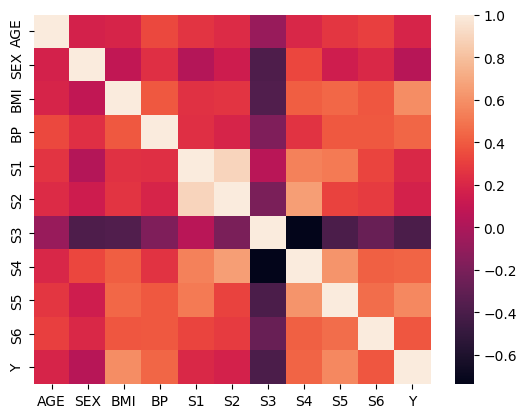

AGE    0.187889
SEX    0.043062
BMI    0.586450
BP     0.441482
S1     0.212022
S2     0.174054
S3    -0.394789
S4     0.430453
S5     0.565883
S6     0.382483
Y      1.000000
Name: Y, dtype: float64


In [5]:
sns.heatmap(df.corr())
plt.show()
print(df.corr()['Y'])

In [6]:
y = df.pop('Y')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(353, 10) (89, 10) (353,) (89,)


In [9]:
# 모델 훈련, 로그, 모델 파일 관리
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
import math

alphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for alpha in alphas:
    # 실험의 기록
    run = experiment.start_logging()
    run.log('alpha_value',alpha)
    model = Ridge(alpha=alpha)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    run.log('mse', mse)
    rmse = math.sqrt(mean_squared_error(y_test,y_pred))
    run.log('rmse', rmse)

    print('model_alpha : {}, Ridge MSE : {}, Ridge RMSE : {}'.format(alpha,mse,rmse))
    
    # 모델을 파일로 저장하는 부분
    model_name = 'model_alpha_' + str(alpha) + '.pkl'
    filename = 'outputs/' + model_name
    joblib.dump(value=model, filename=filename)

    # Azure ML Service에 모델 파일을 업로드하는 부분
    run.upload_file(name=model_name, path_or_stream=filename)

    run.complete()
    print(f"{alpha} experiment completed")
    

model_alpha : 0.1, Ridge MSE : 2557.602271209292, Ridge RMSE : 50.57274237382517
0.1 experiment completed
model_alpha : 0.2, Ridge MSE : 2559.9356649121514, Ridge RMSE : 50.59580679179008
0.2 experiment completed
model_alpha : 0.3, Ridge MSE : 2562.2378257036157, Ridge RMSE : 50.61855218893184
0.3 experiment completed
model_alpha : 0.4, Ridge MSE : 2564.5091337855397, Ridge RMSE : 50.640982749010114
0.4 experiment completed
model_alpha : 0.5, Ridge MSE : 2566.749978438473, Ridge RMSE : 50.66310273205218
0.5 experiment completed
model_alpha : 0.6, Ridge MSE : 2568.9607563181453, Ridge RMSE : 50.68491645764197
0.6 experiment completed
model_alpha : 0.7, Ridge MSE : 2571.1418699285528, Ridge RMSE : 50.70642828999645
0.7 experiment completed
model_alpha : 0.8, Ridge MSE : 2573.2937262543023, Ridge RMSE : 50.72764262465093
0.8 experiment completed
model_alpha : 0.9, Ridge MSE : 2575.4167355365917, Ridge RMSE : 50.74856387659253
0.9 experiment completed
model_alpha : 1, Ridge MSE : 2577.5113

In [10]:
experiment

Name,Workspace,Report Page,Docs Page
diabetes-experiment,labuser92ml,Link to Azure Machine Learning studio,Link to Documentation


In [17]:
# Best Model을 탐색 후 다운로드
minimum_rmse = None
minimum_rmse_runid = None

for exp in experiment.get_runs():
    run_metrics = exp.get_metrics();
    run_details = exp.get_details();

    run_rmse = run_metrics['rmse']
    run_id = run_details['runId']

    # 가장 낮은 RMSE값을 가진 실행 ID를 구하는 부분
    if minimum_rmse is None:
        minimum_rmse = run_rmse
        minimum_rmse_runid = run_id
    else:
        if run_rmse < minimum_rmse:
            minimum_rmse = run_rmse
            minimum_rmse_runid = run_id
print('Best run_id: ' + minimum_rmse_runid)
print('Best RMSE:', minimum_rmse)


Best run_id: da71bd57-25dc-407e-b4d4-ace1d807e737
Best RMSE: 50.57274237382517


In [20]:
# 파일명 확인
from azureml.core import Run
best_run = Run(experiment=experiment, run_id=minimum_rmse_runid)
print(best_run.get_file_names())

best_run.download_file(name=str(best_run.get_file_names()[0]))

['model_alpha_0.1.pkl', 'outputs/model_alpha_0.1.pkl']
